Optimized coefficients: [ 4.69784844e-01  2.26068705e-01 -1.60264997e-01 -4.94867375e-01
  4.77218750e-01  5.39354979e-01 -2.57921793e-01  3.02098202e-02
  9.15749634e-01 -7.51861152e-01  1.81237279e-04  2.65951337e-03
 -1.52289041e-03  1.63685974e-02 -2.05595376e-02  4.28573847e-01
 -7.34542971e-05  4.51972036e-02  6.38369721e-02 -9.12029058e-02
 -1.04285326e-06  2.36412911e-05 -9.59124958e-05  9.42158970e-04
 -9.63377293e-04]


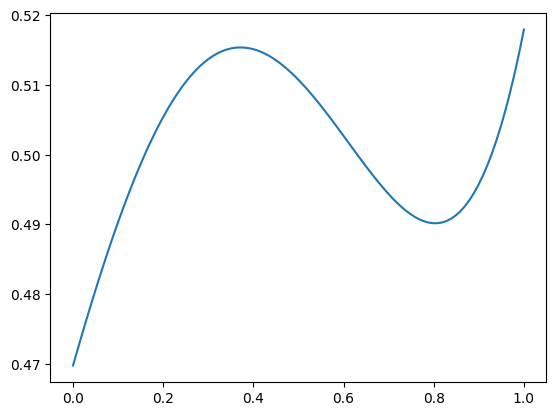

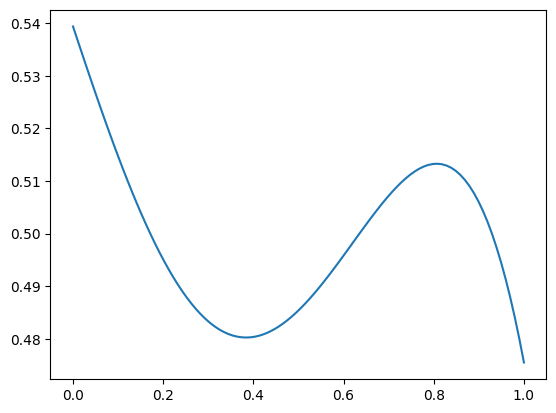

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M = np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5)
alpha_guess = np.hstack((alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M))
initial_conditions = np.array([0.0,0.0,0.0,0.0,0.0]) # x,y,theta,T,M
final_conditions = np.array([1.0,1.0,0.0,0.9,0.0]) # x,y,theta,T,M

def generate_polynomial_basis(t):
  degree = 4
  basis_functions = []
  for d in range(degree + 1):
    basis_functions.append(t**d)
  basis_functions = np.array(basis_functions).T
  derivative_basis_functions = np.zeros_like(basis_functions)
  for d in range(degree):
    derivative_basis_functions[:, d] = (d + 1) * basis_functions[:, d + 1]
  second_derivative_basis_functions = np.zeros_like(basis_functions)
  for d in range(degree - 1):
    second_derivative_basis_functions[:, d] = (d + 1) * derivative_basis_functions[:, d + 1]
  return basis_functions, derivative_basis_functions, second_derivative_basis_functions
t = np.linspace(0, 1, 100)  # normalized Time
basis_functions, derivative_basis_functions, second_derivative_basis_functions = generate_polynomial_basis(t)
def Error(alpha):
  mass = 1
  inertia_z = 1
  alpha_x_slice = alpha[:5]
  alpha_y_slice = alpha[5:2*5]
  alpha_theta_slice = alpha[2*5:3*5]
  alpha_T = alpha[3*5:4*5]
  alpha_M = alpha[4*5:25]
  error_x = np.sum((mass * second_derivative_basis_functions @ alpha_x_slice - \
                    basis_functions @ alpha_T * np.cos(basis_functions @ alpha_theta_slice))**2)
  error_y = np.sum((mass * second_derivative_basis_functions @ alpha_y_slice - \
                    basis_functions @ alpha_T * np.sin(basis_functions @ alpha_theta_slice))**2)
  error_M = np.sum((inertia_z * second_derivative_basis_functions @ alpha_theta_slice - basis_functions @ alpha_M)**2)

  error_IC = np.sum((basis_functions @ alpha_x_slice - initial_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - initial_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - initial_conditions[2])**2 + \
                    (basis_functions @ alpha_T - initial_conditions[3])**2 + \
                    (basis_functions @ alpha_M - initial_conditions[4])**2)
  error_FC = np.sum((basis_functions @ alpha_x_slice - final_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - final_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - final_conditions[2])**2 + \
                    (basis_functions @ alpha_T - final_conditions[3])**2 + \
                    (basis_functions @ alpha_M - final_conditions[4])**2)
  J = error_x + error_y + error_M + 10*error_IC + 10*error_FC
  return J

def x(time):
  generate_polynomial_basis(time)[0]@alpha_guess[:5]
def y(time):
  generate_polynomial_basis(time)[0]@alpha_guess[5:2*5]
def theta(time):
  generate_polynomial_basis(time)[0]@alpha_guess[2*5:3*5]
def T(time):
  generate_polynomial_basis(time)[0]@alpha_guess[3*5:4*5]
def M(time):
  generate_polynomial_basis(time)[0]@alpha_guess[4*5:5*5]

# Initial guess for alpha
alpha_guess = np.zeros(25)

# Minimize the error function
result = minimize(Error, alpha_guess, options={'maxiter': 10000})

# Extract the optimized coefficients
optimized_alpha = result.x

# Print the result
print("Optimized coefficients:", optimized_alpha)
plt.plot(t,np.dot(basis_functions,optimized_alpha[:5]))
plt.show()
plt.plot(t,np.dot(generate_polynomial_basis(t)[0],optimized_alpha[5:10]))
plt.show()